#### Demo Notebook

In this notebook we will 
- use the Vision AI Service to OCR an image created from a PDF page.
- identify any diagrams on the page and cut them out and save them to disk without using Open CV.


In [ ]:
# install if needed
# For Image Analysis 3.2
# %pip install azure-cognitiveservices-vision-computervision
# or
# pip install --upgrade azure-cognitiveservices-vision-computervision
# for Image Analysis 4.0
# %pip install azure-ai-vision

#### Using Image Analysis 4.0 for OCR + Images

Prerequisites:  
1. Create a computer vision resource   
2. Update the .env file with your key and endpoint

In [1]:
import os
import openai
from typing import List
import azure.ai.vision as sdk
from dotenv import load_dotenv
# get env variables from .env file
load_dotenv()
#
# now we will set local vars from the env variables
#
# *****************************************
# Configure Vision API
# *****************************************
service_options = sdk.VisionServiceOptions(os.environ["AZURE_VISION_ENDPOINT"],
                                           os.environ["AZURE_VISION_KEY"])
print("done")

done


#### Covert PDF page to Image

You can't pass PDFs to the service, so we must first convert it to images.
I will just do one page.

In [125]:
import pypdfium2 as pdfium
import numpy as np

# Example document FMDS0200 has a diagram on page 23 (printed page 24)
# Example document FMDS0128 has a photo on page 43 (printed page 44)
# 
#*****************************************
# Function to covert PDF page to image
#*****************************************
def pdf_page_to_image(pdf_document_path, page_no):
    import pypdfium2 as pdfium
    filepath = pdf_document_path
    pdf = pdfium.PdfDocument(filepath)

    # render a single page (in this case: the first one)
    page = pdf[page_no]
    pil_image = page.render(scale=4).to_pil()
    # open cv will need a numpy array
    #image=np.array(pil_image)
    return pil_image

def pdf_page_to_np_image(pdf_document_path, page_no):
    import pypdfium2 as pdfium
    filepath = pdf_document_path
    pdf = pdfium.PdfDocument(filepath)

    # render a single page (in this case: the first one)
    page = pdf[page_no]
    pil_image = page.render(scale=4).to_pil()
    # open cv will need a numpy array
    np_image=np.array(pil_image)
    return np_image

#**************
# Main Code
#**************
# using page 43
filepath = "./FMDS0128.pdf"
page_to_explore=43
#
# convert the page to an image
pil_image=pdf_page_to_image(filepath, page_to_explore)
#
#save the page
image_name="page_" + str(page_to_explore)+ ".jpg"
pil_image.save(image_name)
#
print("image {} saved!".format(image_name))


image page_43.jpg saved!


#### View the Image

Notice the photo.

getting image page_43.jpg


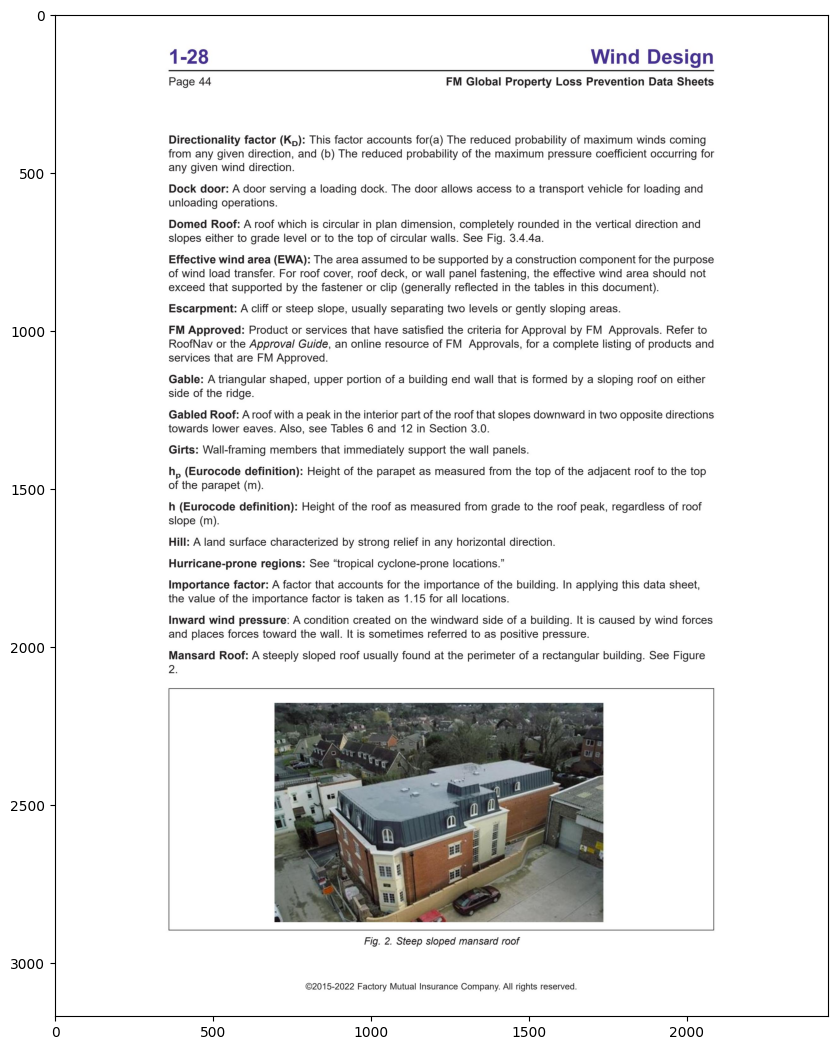

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
#
rcParams['figure.figsize'] = 13 ,13
print("getting image {}".format(image_name))
image = plt.imread(image_name)
plt.imshow(image)
plt.show()

#### Now lets call the vision's service's Image Analysis API to perform OCR

There are a lot of options possible with the Vision Service.
I will just use the base model with no options.

In [4]:
import os
import azure.ai.vision as sdk

#service_options = sdk.VisionServiceOptions(os.environ["AZURE_VISION_ENDPOINT"],
#                                           os.environ["AZURE_VISION_KEY"])

# This can be called for a local file or a URL
# I am using a local file
vision_source = sdk.VisionSource(filename=image_name)
#
# below is how I would contruct the location if using a URL
# vision_source = sdk.VisionSource(url="https://learn.microsoft.com/azure/ai-services/computer-vision/media/quickstarts/presentation.png")
#
analysis_options = sdk.ImageAnalysisOptions()

analysis_options.features = (
    sdk.ImageAnalysisFeature.CAPTION |
    sdk.ImageAnalysisFeature.TEXT
)

analysis_options.language = "en"

analysis_options.gender_neutral_caption = True

image_analyzer = sdk.ImageAnalyzer(service_options, vision_source, analysis_options)

result = image_analyzer.analyze()

if result.reason == sdk.ImageAnalysisResultReason.ANALYZED:

    if result.caption is not None:
        print(" Caption:")
        print("   '{}', Confidence {:.4f}".format(result.caption.content, result.caption.confidence))

    if result.text is not None:
        print(" Text:")
        for line in result.text.lines:
            points_string = "{" + ", ".join([str(int(point)) for point in line.bounding_polygon]) + "}"
            print("   Line: '{}', Bounding polygon {}".format(line.content, points_string))
            for word in line.words:
                points_string = "{" + ", ".join([str(int(point)) for point in word.bounding_polygon]) + "}"
                print("     Word: '{}', Bounding polygon {}, Confidence {:.4f}"
                      .format(word.content, points_string, word.confidence))

else:

    error_details = sdk.ImageAnalysisErrorDetails.from_result(result)
    print(" Analysis failed.")
    print("   Error reason: {}".format(error_details.reason))
    print("   Error code: {}".format(error_details.error_code))
    print("   Error message: {}".format(error_details.message))

 Caption:
   'a close-up of a document', Confidence 0.6978
 Text:
   Line: '1-28', Bounding polygon {362, 100, 493, 100, 490, 160, 358, 160}
     Word: '1-28', Bounding polygon {361, 100, 480, 100, 480, 160, 361, 160}, Confidence 0.9890
   Line: 'Wind Design', Bounding polygon {1687, 96, 2086, 101, 2085, 167, 1686, 161}
     Word: 'Wind', Bounding polygon {1689, 96, 1844, 100, 1843, 165, 1686, 160}, Confidence 0.9890
     Word: 'Design', Bounding polygon {1862, 100, 2077, 102, 2079, 167, 1861, 165}, Confidence 0.9970
   Line: 'Page 44', Bounding polygon {354, 189, 498, 191, 497, 229, 353, 227}
     Word: 'Page', Bounding polygon {356, 189, 443, 191, 440, 229, 354, 228}, Confidence 0.9890
     Word: '44', Bounding polygon {451, 191, 496, 192, 492, 230, 448, 229}, Confidence 0.9980
   Line: 'FM Global Property Loss Prevention Data Sheets', Bounding polygon {1225, 187, 2086, 188, 2086, 232, 1225, 231}
     Word: 'FM', Bounding polygon {1227, 188, 1276, 188, 1276, 232, 1228, 232}, Confiden

#### Exploring what was returned in the Result
Notice I can get properties like:
Image height: 3168  
Image width: 2447  
Model version: 2023-02-01-preview  
a Caption:  'a document with text and diagrams'  
a Confidence 0.6122  
and line by line the text for that Line: and also each word in that line  
and bounding boxes coordinates for everything  

For a full description of what is available 
see: https://learn.microsoft.com/en-us/python/api/azure-ai-vision/azure.ai.vision.imageanalysisresultdetails?view=azure-python-preview  


In [21]:
if result.reason == sdk.ImageAnalysisResultReason.ANALYZED:
    print("\n*********")
    print("Basic:")
    print("*********")
    print(" Image height: {}".format(result.image_height))
    print(" Image width: {}".format(result.image_width))
    print(" Model version: {}".format(result.model_version))

    if result.caption is not None:
        print("\n*********")
        print("Caption:")
        print("*********")
        print("   '{}', Confidence {:.4f}".format(result.caption.content, result.caption.confidence))

    if result.dense_captions is not None:
        print("\n**************************")
        print("Dense Captions:")
        print("**************************")
        for caption in result.dense_captions:
            print("   '{}', {}, Confidence: {:.4f}".format(caption.content, caption.bounding_box, caption.confidence))

    if result.objects is not None:
        print("\n**************************")
        print("Objects:")
        print("**************************")
        for object in result.objects:
            print("   '{}', {}, Confidence: {:.4f}".format(object.name, object.bounding_box, object.confidence))

    if result.tags is not None:
        print("\n**************************")
        print("Tags:")
        print("**************************")
        for tag in result.tags:
            print("   '{}', Confidence {:.4f}".format(tag.name, tag.confidence))

    if result.people is not None:
        print("\n**************************")
        print("People:")
        print("**************************")
        for person in result.people:
            print("   {}, Confidence {:.4f}".format(person.bounding_box, person.confidence))

    if result.crop_suggestions is not None:
        print("\n**************************")
        print("Crop Suggestions:")
        print("**************************")
        for crop_suggestion in result.crop_suggestions:
            print("   Aspect ratio {}: Crop suggestion {}"
                  .format(crop_suggestion.aspect_ratio, crop_suggestion.bounding_box))

    if result.text is not None:
        print("\n*******************************")
        print("Text: (showing just 5 lines...)")
        print("********************************")
        line_ctr=0
        for line in result.text.lines:
            line_ctr+=1
            if line_ctr > 5:
                break
            points_string = "{" + ", ".join([str(int(point)) for point in line.bounding_polygon]) + "}"
            print("   Line: '{}', Bounding polygon {}".format(line.content, points_string))
            for word in line.words:
                points_string = "{" + ", ".join([str(int(point)) for point in word.bounding_polygon]) + "}"
                print("     Word: '{}', Bounding polygon {}, Confidence {:.4f}"
                      .format(word.content, points_string, word.confidence))
    skip=1
    result_details = sdk.ImageAnalysisResultDetails.from_result(result)
    print("\n*****************************************")
    if skip==1:
        print("Result details: (only partially shown...)")
        print("*****************************************")
    if skip==0:
        print(" Result details:")
        print("**************************")
    print("   Image ID: {}".format(result_details.image_id))
    print("   Result ID: {}".format(result_details.result_id))
    print("   Connection URL: {}".format(result_details.connection_url))
    if skip==0:
        print("   JSON result: {}".format(result_details.json_result))

else:
    print("\n**************************")
    error_details = sdk.ImageAnalysisErrorDetails.from_result(result)
    print("Analysis failed.")
    print("**************************")
    print("   Error reason: {}".format(error_details.reason))
    print("   Error code: {}".format(error_details.error_code))
    print("   Error message: {}".format(error_details.message))


*********
Basic:
*********
 Image height: 3168
 Image width: 2447
 Model version: 2023-02-01-preview

*********
Caption:
*********
   'a close-up of a document', Confidence 0.6978

*******************************
Text: (showing just 5 lines...)
********************************
   Line: '1-28', Bounding polygon {362, 100, 493, 100, 490, 160, 358, 160}
     Word: '1-28', Bounding polygon {361, 100, 480, 100, 480, 160, 361, 160}, Confidence 0.9890
   Line: 'Wind Design', Bounding polygon {1687, 96, 2086, 101, 2085, 167, 1686, 161}
     Word: 'Wind', Bounding polygon {1689, 96, 1844, 100, 1843, 165, 1686, 160}, Confidence 0.9890
     Word: 'Design', Bounding polygon {1862, 100, 2077, 102, 2079, 167, 1861, 165}, Confidence 0.9970
   Line: 'Page 44', Bounding polygon {354, 189, 498, 191, 497, 229, 353, 227}
     Word: 'Page', Bounding polygon {356, 189, 443, 191, 440, 229, 354, 228}, Confidence 0.9890
     Word: '44', Bounding polygon {451, 191, 496, 192, 492, 230, 448, 229}, Confidence 0.9

#### If there is a diagram with text in the diagram ...
The text from the diagram on the page is also returned.  
If it is a photo with no text in the photo, you just get the photo.   
(Which is the case on page 43). Nothing extra is returned.  

But I can find text that references the figure!

In [42]:
start_flag=0
if result.text is not None:
    for line in result.text.lines:
        if line.content.startswith("@"):
            # found footer
            break
        if line.content.find("See Fig")>-1:
            print("\n******  start of text referencing a figure  *******\n")
            print('\t'+ line.content)
            start_flag=1
            if line.content.endswith("."):
                # found end of reference
                print("\n******  End of reference *******")
                start_flag=0
            continue
        if start_flag==1:
            print('\t'+ line.content)
            if line.content.endswith("."):
                print("\n******  End of reference *******")
                start_flag=0
        if line.content.startswith("Fig. "):
            print("\n******  start of caption  *******\n")
            print('\t'+ line.content)
            print("\n******  End of caption *******")
            continue


 Text:

******  start of text referencing a figure  *******

	slopes either to grade level or to the top of circular walls. See Fig. 3.4.4a.

******  End of reference *******

******  start of text referencing a figure  *******

	Mansard Roof: A steeply sloped roof usually found at the perimeter of a rectangular building. See Figure
	2.

******  End of reference *******

******  start of caption  *******

	Fig. 2. Steep sloped mansard roof

******  End of caption *******


#### Easy way to get all text content
Use the json_result obtained from:  
result_details = sdk.ImageAnalysisResultDetails.from_result(result)

In [17]:
import json
# The API Returned result
# in previous cell I called the following
# result_details = sdk.ImageAnalysisResultDetails.from_result(result)
# which returns a json string that I can parse as below
#
json_result=json.loads(result_details.json_result)
print(json_result["readResult"]["content"])


1-28
Wind Design
Page 44
FM Global Property Loss Prevention Data Sheets
Directionality factor (KD): This factor accounts for(a) The reduced probability of maximum winds coming
from any given direction, and (b) The reduced probability of the maximum pressure coefficient occurring for
any given wind direction.
Dock door: A door serving a loading dock. The door allows access to a transport vehicle for loading and
unloading operations.
Domed Roof: A roof which is circular in plan dimension, completely rounded in the vertical direction and
slopes either to grade level or to the top of circular walls. See Fig. 3.4.4a.
Effective wind area (EWA): The area assumed to be supported by a construction component for the purpose
of wind load transfer. For roof cover, roof deck, or wall panel fastening, the effective wind area should not
exceed that supported by the fastener or clip (generally reflected in the tables in this document).
Escarpment: A cliff or steep slope, usually separating two levels 

#### Can the Vision Service detect the diagram (Photos, line drawings, tables)?

When we called the API in an eaarlier cell, we only asked for two options by setting the analysis_options.features  

analysis_options.features = (
    sdk.ImageAnalysisFeature.CAPTION |
    sdk.ImageAnalysisFeature.TEXT
    )

Lets try some additional options:

In [65]:
import os
import azure.ai.vision as sdk
from io import BytesIO
from azure.ai.vision import ImageSourceBuffer

def convert_image_to_buffer(pil_image):
    #************************  useful code here ****************************
    # The sdk's VisionSource can be called for a local file or a URL or a ImageSourceBuffer
    # I have a pillow image in memory and I want to avoid saving it to disk
    #
    # To convert it to an ImageSourceBuffer
    #
    # 1. Convert the PIL image to a bytes object
    #
    byte_stream = BytesIO()
    pil_image.save(byte_stream, format='PNG')
    byte_stream = byte_stream.getvalue()
    # I now have a bytes object

    # I can create an ImageSourceBuffer from the bytes object
    # 
    # 2. I first create the buffer, notice I use an empty constructor
    #
    image_source_buffer = ImageSourceBuffer()

    # 3. and then use its writer to write the bytes object into the buffer
    image_source_buffer.image_writer.write(byte_stream)
    return image_source_buffer

In [73]:
#*********************
# switching to Page 22 !!!
# of FMDS0200.pdf
#*********************
import os
import azure.ai.vision as sdk
from io import BytesIO
from azure.ai.vision import ImageSourceBuffer

# using page 22
filepath = "./FMDS0200.pdf"
page_to_explore=22
#
# convert the page to an image
page_22_image=pdf_page_to_image(filepath, page_to_explore)
#
# convert the image to a buffer
image_source_buffer=convert_image_to_buffer(page_22_image)
#
#******************************************************************************
#
# I can then pass my image_source_buffer to the VisionSource constructor
vision_source= sdk.VisionSource(image_source_buffer=image_source_buffer)


analysis_options = sdk.ImageAnalysisOptions()

analysis_options.features = (
    sdk.ImageAnalysisFeature.CAPTION |
    sdk.ImageAnalysisFeature.TEXT |
    sdk.ImageAnalysisFeature.OBJECTS |
    sdk.ImageAnalysisFeature.TAGS |
    sdk.ImageAnalysisFeature.CROP_SUGGESTIONS |
    #sdk.ImageAnalysisFeature.FACES |
    sdk.ImageAnalysisFeature.DENSE_CAPTIONS |
    sdk.ImageAnalysisFeature.PEOPLE 
)

analysis_options.language = "en"
analysis_options.gender_neutral_caption = True
# Call the API
image_analyzer = sdk.ImageAnalyzer(service_options, vision_source, analysis_options)
#
# get the result (we will use this again)
result = image_analyzer.analyze()

print("Page 22 has been analyzed")

Page 22 has been analyzed


#### Now we interrogate the result

In [74]:
if result.reason == sdk.ImageAnalysisResultReason.ANALYZED:
    if result.people is not None:
        if len(result.people) !=0:
            print(" People were found in the image")
    if result.objects is not None:
        if len(result.objects) !=0:
            print(" Objects were found in the image")
    if result.tags is not None:
        if len(result.tags) !=0:
            print(" Tags were found in the image")
    if result.segmentation_result is not None:
        if len(result.segmentation_result) !=0:
            print(" segmentation_results were found in the image")
    if result.dense_captions is not None:
        if len(result.dense_captions) !=0:
            print(" dense_captions were found in the image")
    if result.crop_suggestions is not None:
        if len(result.crop_suggestions) !=0:
            print(" crop_suggestions were found in the image")
print("done!")


 Objects were found in the image
 Tags were found in the image
 dense_captions were found in the image
 crop_suggestions were found in the image
done!


#### Exploring those further we see that the API does see the following:

For example document FMDS0200 that has a diagram on page 22 (printed page 23), we get the caption:  

'a document with text and a diagram', Rectangle(x=0, y=0, w=2447, h=3168), Confidence: 0.6435

We also get:  

'diagram of a diagram of a compressor and tank', Rectangle(x=324, y=1809, w=1768, h=841), Confidence: 0.6522

and several more

(Below we are still using page 22)

In [84]:
if result.dense_captions is not None:
    print(" Dense Captions:")
    for caption in result.dense_captions:
        print("   '{}', {}, Confidence: {:.4f}".format(caption.content, caption.bounding_box, caption.confidence))

if result.objects is not None:
    print(" Objects:")
    for object in result.objects:
        print("   '{}', {}, Confidence: {:.4f}".format(object.name, object.bounding_box, object.confidence))

if result.tags is not None:
    print(" Tags:")
    for tag in result.tags:
        print("   '{}', Confidence {:.4f}".format(tag.name, tag.confidence))

if result.people is not None:
    print(" People:")
    for person in result.people:
        print("   {}, Confidence {:.4f}".format(person.bounding_box, person.confidence))

if result.crop_suggestions is not None:
    print(" Crop Suggestions:")
    for crop_suggestion in result.crop_suggestions:
        print("   Aspect ratio {}: Crop suggestion {}"
                .format(crop_suggestion.aspect_ratio, crop_suggestion.bounding_box))

 Dense Captions:
   'a document with text and a diagram', Rectangle(x=0, y=0, w=2447, h=3168), Confidence: 0.6435
   'diagram of a diagram of a compressor and tank', Rectangle(x=324, y=1809, w=1768, h=841), Confidence: 0.6522
   'a document with text and a diagram', Rectangle(x=0, y=0, w=2418, h=3120), Confidence: 0.6340
   'a close-up of a document', Rectangle(x=285, y=187, w=1761, h=1517), Confidence: 0.7315
   'a close-up of a sign', Rectangle(x=341, y=10, w=1690, h=153), Confidence: 0.8139
   'a white background with black text', Rectangle(x=353, y=1370, w=1693, h=366), Confidence: 0.7199
   'a close-up of a sign', Rectangle(x=352, y=1329, w=1723, h=151), Confidence: 0.7358
   'a close up of a sign', Rectangle(x=360, y=1607, w=1702, h=150), Confidence: 0.6295
   'a close up of black text', Rectangle(x=315, y=1022, w=1748, h=163), Confidence: 0.6914
 Objects:
   'text', Rectangle(x=398, y=189, w=1789, h=2364), Confidence: 0.6450
 Tags:
   'text', Confidence 1.0000
   'screenshot', C

### The dense captions represent 
1. the entire document  because the size is the entire page Rectangle(x=0, y=0, w=2447, h=3168)
2. a diagam image        a smaller rectangle
3. parts in the diagram  a smaller rectangles

You can tell what is nested by looking at the y coordinate and height

In [116]:
caption_coords=[]
for caption in result.dense_captions:
    top_left_y_coordinate=caption.bounding_box.y
    bottom_left_y_coordinate=caption.bounding_box.y+caption.bounding_box.h
    height=caption.bounding_box.h
    caption=caption.content
    caption_coords.append([top_left_y_coordinate, bottom_left_y_coordinate, height, caption])
for i in range(len(caption_coords)):
    print(caption_coords[i])


[0, 3168, 3168, 'a document with text and a diagram']
[1809, 2650, 841, 'diagram of a diagram of a compressor and tank']
[0, 3120, 3120, 'a document with text and a diagram']
[187, 1704, 1517, 'a close-up of a document']
[10, 163, 153, 'a close-up of a sign']
[1370, 1736, 366, 'a white background with black text']
[1329, 1480, 151, 'a close-up of a sign']
[1607, 1757, 150, 'a close up of a sign']
[1022, 1185, 163, 'a close up of black text']


#### Draw the rectangle onto the page

The cell below is for the example document FMDS0200 
It has two tables on page 22 (printed page 23)

Unlike what we saw earlier where coordinates were returned in inches from the layout API when analyzing a PDF,  
when analyzing an image, the coordinates are in pixels so no conversion is needed.

   Line: 'Fig. 2.2.5.4.3. Piping arrangement when using air as the gaseous medium for a refrigerated-area sprinkler system', Bounding polygon {397, 2664, 2042, 2664, 2041, 2704, 397, 2703}
397.0 2664.0 2042.0 2664.0 2041.0 2704.0 397.0 2703.0
***************************************************************
diagram bottom left = 324,1809 and diagrams bottom right = 2092,1809 
diagram top left = 324,2650 and diagrams top right = 2092,2650 
title bottom left = 397.0,2664.0 and titles bottom right = 2042.0,2664.0 
title top left = 397.0,2703.0 and titles top right = 2041.0,2704.0 


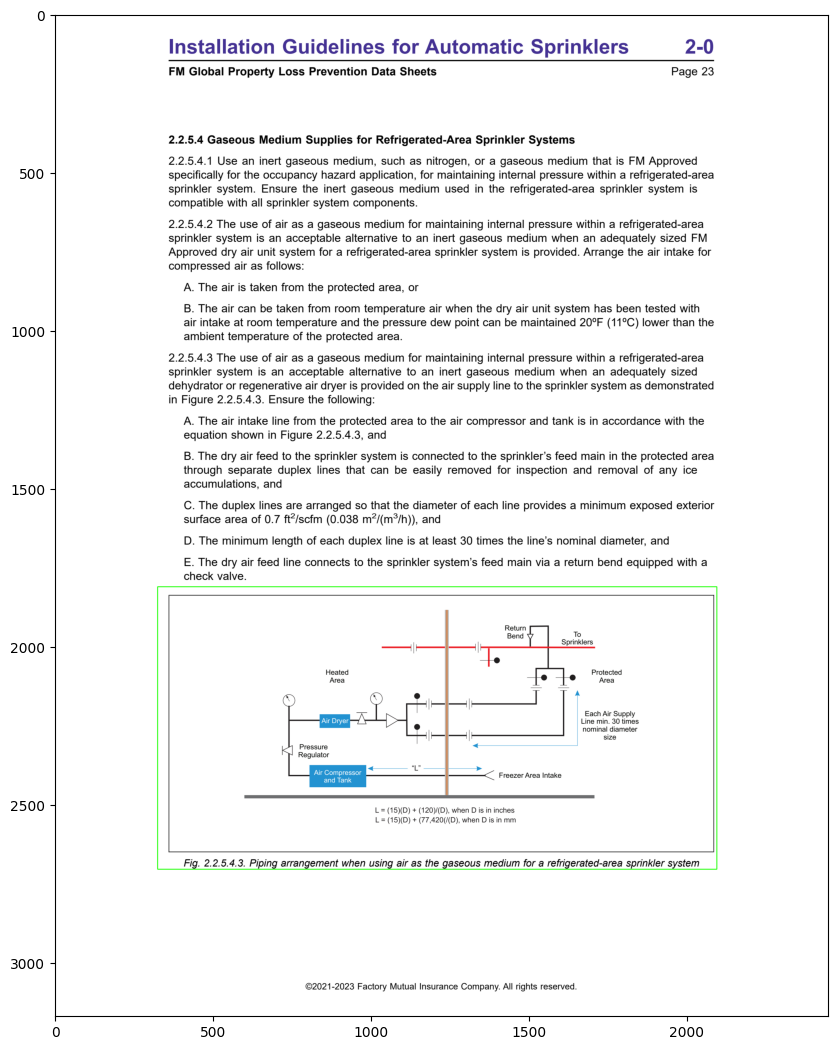

In [121]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cv2 
#
# using page 22
filepath = "./FMDS0200.pdf"
page_to_explore=22
#
# convert the page to an image
page_22_image=pdf_page_to_image(filepath, page_to_explore)
#
# convert the image to a buffer
image_source_buffer=convert_image_to_buffer(page_22_image)

# lets first find the lines that start with "Fig. "
# They will be the line below the diagram
figure_titles_found=[]
#
# we are using the OCR result from prior cell
#
for line in result.text.lines:
    if line.content is not None:
        if line.content.startswith("Fig. "):
            points_string = "{" + ", ".join([str(int(point)) for point in line.bounding_polygon]) + "}"
            print("   Line: '{}', Bounding polygon {}".format(line.content, points_string))
            # line.bounding_polygon is a list with 8 values
            figure_titles_found.append(line.bounding_polygon)
# loop through and draw the rectangles around the titles
# captions represent the rectangle where the diagram may be
for caption in result.dense_captions:
    if caption.content.find("diagram")>-1:
        rect = caption.bounding_box
        # draw the rectangle
        x, y, w, h = rect.x, rect.y, rect.w, rect.h
        # We  dont want any 0,0s
        if x==0 and y==0:
            continue
        # the lowest y coordinate of the diagram should be greater than the y coordinate of the caption
        # lets use the bottom left coordinate of the line content
        title_x0, title_y0, title_x1, title_y1, title_x2, title_y2, title_x3, title_y3  = figure_titles_found[0]
        print(title_x0, title_y0, title_x1, title_y1, title_x2, title_y2, title_x3, title_y3)
        # These come back starting with the top left and going clockwise
        #
        #                      x0, y0-------> x1, y1
        #                        |               |
        #                        |               |
        #                      x3, y3<------- x2, y2
        #
        #
        #
        # titles represent the totle of the diagram that appreas directly below the diagram
        # compare the y coordinate of the caption ("y") to the y coordinate of the bottom left point of the title 
        # If the title's top y is greater than the caption's top y , the title would be above the diagram not below
        # that is wrong so we dont want it
        if y+h >= title_y0:
            continue
        # If the title's bottom y is greater than the caption's bottom y , the title would be inside the diagram not below
        # that is wrong so we dont want it
        if y >= title_y3:
            continue
        # so now we should have good ones left
        pt1=(x,y)
        pt2=(x+w,y+h)
        print("***************************************************************")
        print("diagram bottom left = {},{} and diagrams bottom right = {},{} ".format( x,y,x+w,y))
        print("diagram top left = {},{} and diagrams top right = {},{} ".format( x,y+h,x+w,y+h))
        print("title bottom left = {},{} and titles bottom right = {},{} ".format( title_x0, title_y0 , title_x1, title_y1))
        print("title top left = {},{} and titles top right = {},{} ".format( title_x3, title_y3 , title_x2, title_y2))
        #
        # if we use the titles bottom y when drawing the green box we will get the title in the image too
        # create a new point using the title bottom right coordinates
        # avoid the error: name 'point' is not defined
        # the box must go aroung the title which is below the diagram
        title_left_top_corner=(int(title_x3), int(title_y3))
        title_right_top_corner=(int(title_x2),int(title_y2))
        title_right_bottom_corner=(int(title_x1), int(title_y1))
        title_left_bottom_corner=(int(title_x0), int(title_y0))
        # draw the rectangle around the diagram and the title
        # so the top of the rectangle to draw will use the diagrams top y
        # and use the titles bottom y
        x_top_left = int(min(title_x3,x))
        y_top_left = int(max(title_y3,y+h))
        x_bottom_right = int(max(title_x1,x+w))
        y_bottom_right = int(min(title_y1,y))
        # draw the rectangle
        modded_image=cv2.rectangle(image,(x_top_left,y_top_left),(x_bottom_right,y_bottom_right),(36,255,12),2)
        #cv2.rectangle(image,pt1,title_right_bottom_corner,(0,255,0),3)

# to show the image convert the PIL image to a numpy array
# because matplotlib expects a numpy array
image = np.array(page_22_image)
plt.figure(figsize=(13,13))
plt.imshow(modded_image)
plt.show()


## Lets save the diagram  to disk
Cell below is for example document FMDS0200 that has a diagram on page 23 (printed page 24)

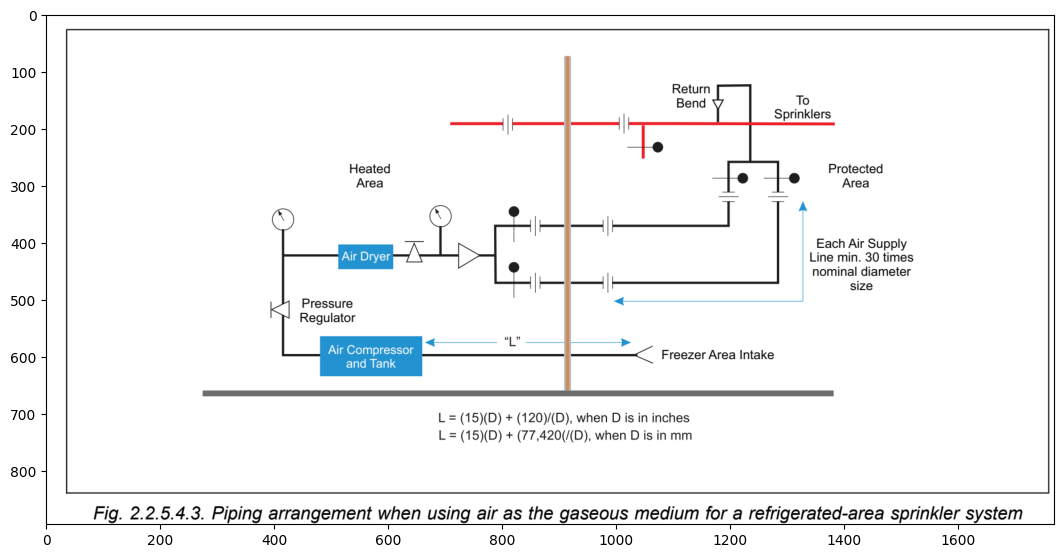

In [126]:
def cutout_image_around_both(np_image, result):
    # call the function to do the cutouts
    # always pass in a single image (of the page)
    # and the result from the API
    cutouts=[]
    titles_to_keep=[]
    figure_titles_found=[]
    for line in result.text.lines:
        if line.content is not None:
            if line.content.startswith("Fig."):
                points_string = "{" + ", ".join([str(int(point)) for point in line.bounding_polygon]) + "}"
                #print("   Line: '{}', Bounding polygon {}".format(line.content, points_string))
                # line.bounding_polygon is a list with 8 values
                figure_titles_found.append(line.bounding_polygon)
                mystart=line.content.find(" ")
                myend=line.content.find(" ", mystart+1)
                title_to_keep=line.content[mystart+1:myend]
                title_to_keep=title_to_keep[:-1]
                titles_to_keep.append(title_to_keep)
    # loop through and draw the rectangles around the titles
    # captions represent the rectangle where the diagram may be
    for caption in result.dense_captions:
        if caption.content.find("diagram")>-1:
            rect = caption.bounding_box
            # draw the rectangle
            x, y, w, h = rect.x, rect.y, rect.w, rect.h
            # We  dont want any 0,0s
            if x==0 and y==0:
                continue
            # the lowest y coordinate of the diagram should be greater than the y coordinate of the caption
            # lets use the bottom left coordinate of the line content
            title_x0, title_y0, title_x1, title_y1, title_x2, title_y2, title_x3, title_y3  = figure_titles_found[0]
            # Note that this come in starting with the top left and going clockwise
            #
            # titles represent the totle of the diagram that appreas directly below the diagram
            # compare the y coordinate of the caption ("y") to the y coordinate of the bottom left point of the title 
            # If the title's top y is greater than the caption's top y , the title would be above the diagram not below
            # that is wrong so we dont want it
            if y+h >= title_y0:
                continue
            # If the title's bottom y is greater than the caption's bottom y , the title would be inside the diagram not below
            # that is wrong so we dont want it
            if y >= title_y3:
                continue
            # so now we should have good ones left
            #
            #if we use  the titles bottom y when drawing the green box we will get the title in the image too
            # create a new point using the title bottom right coordinates
            # avoid the error: name 'point' is not defined
            # the box must go aroung the title which is below the diagram
            title_left_top_corner=(int(title_x3), int(title_y3))
            title_right_top_corner=(int(title_x2),int(title_y2))
            title_right_bottom_corner=(int(title_x1), int(title_y1))
            title_left_bottom_corner=(int(title_x0), int(title_y0))
            # draw the rectangle around the diagram and the title
            # so the top of the rectangle to draw will use the diagrams top y
            # and use the titles bottom y
            min_x= int(min(title_x3,x))
            max_y = int(max(title_y3,y+h))
            max_x = int(max(title_x1,x+w))
            min_y = int(min(title_y1,y))
            # draw the rectangle
            cutout_image=np_image[min_y:max_y, min_x:max_x]
            cutouts.append(cutout_image)   
    # return the cutout images
    return cutouts, titles_to_keep


# main code
import cv2 
import matplotlib.pyplot as plt
from matplotlib import rcParams
#
# using page 22
filepath = "./FMDS0200.pdf"
page_to_explore=22
#
# convert the page to an image
page_22_image=pdf_page_to_np_image(filepath, page_to_explore)
#
cutouts_out, titles_to_keep = cutout_image_around_both(page_22_image, result)
#
# Now lets loop through the images and save them to disk
for image in cutouts_out:
    for title in titles_to_keep:
        # save it to disk
        final_title="Figure " + title + ".png"
        # write it to disk
        cv2.imwrite(str(final_title), image)
# loop through and show the images
for img in cutouts_out:
    plt.figure(figsize=(13,13))
    plt.imshow(img)
    plt.show()